A **PCAP** (Packet Capture) file is a data format used primarily in network monitoring and analysis applications to store intercepted packets of data traffic over a network. PCAP files provide a detailed and comprehensive snapshot of network traffic, capturing every packet that transits the network interfaces according to the given criteria set by the capture process.

# Primarily contains: Packet data, packet headers,timestamps,metadata

In [ ]:
!pip install scapy

We are generally taking pcap file from **wireshark** that help as network monitoring and anaysis tools

Saving fuzz-2006-06-26-2594.pcap to fuzz-2006-06-26-2594.pcap


Processing packets:   0%|          | 0/691 [00:00<?, ?packet/s]

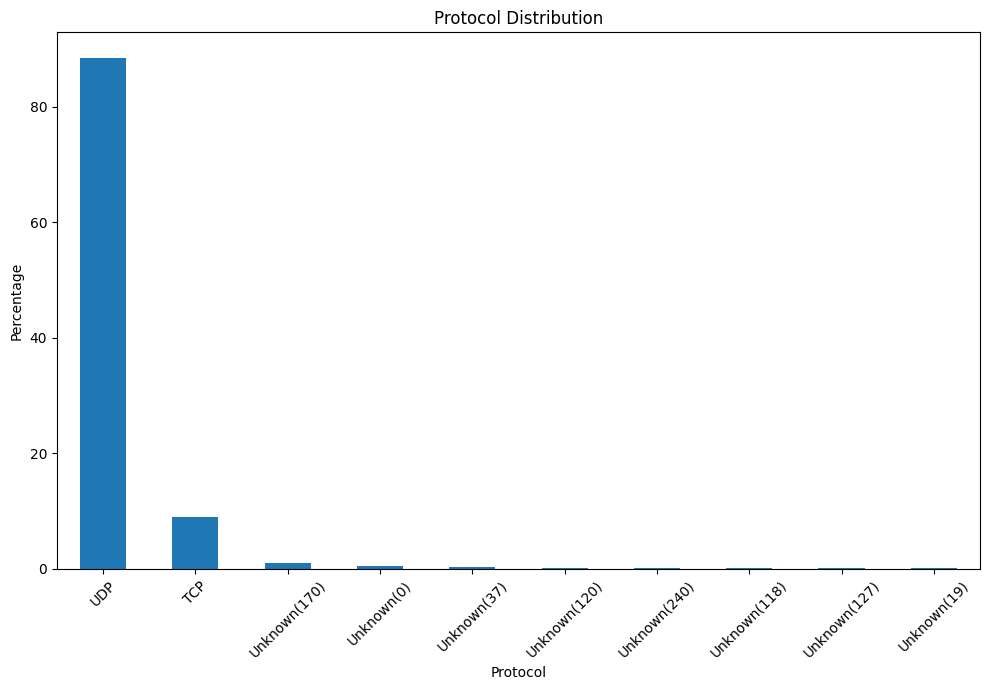

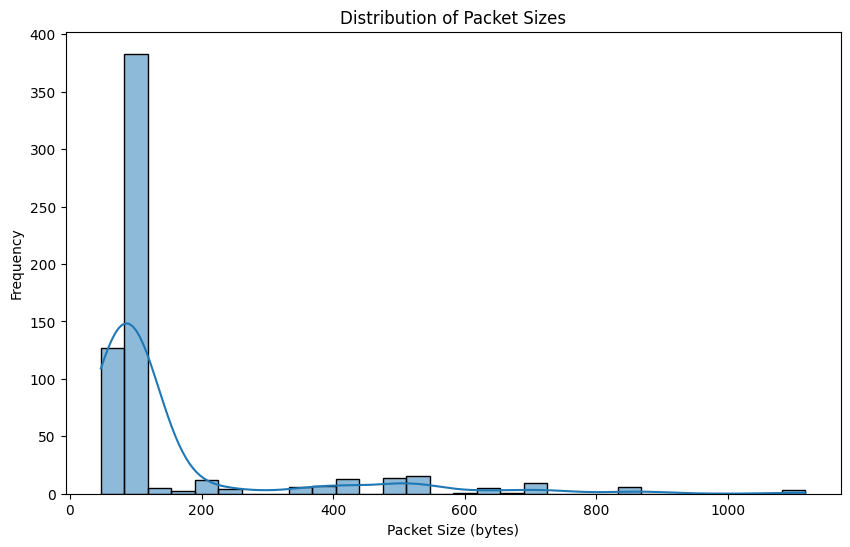

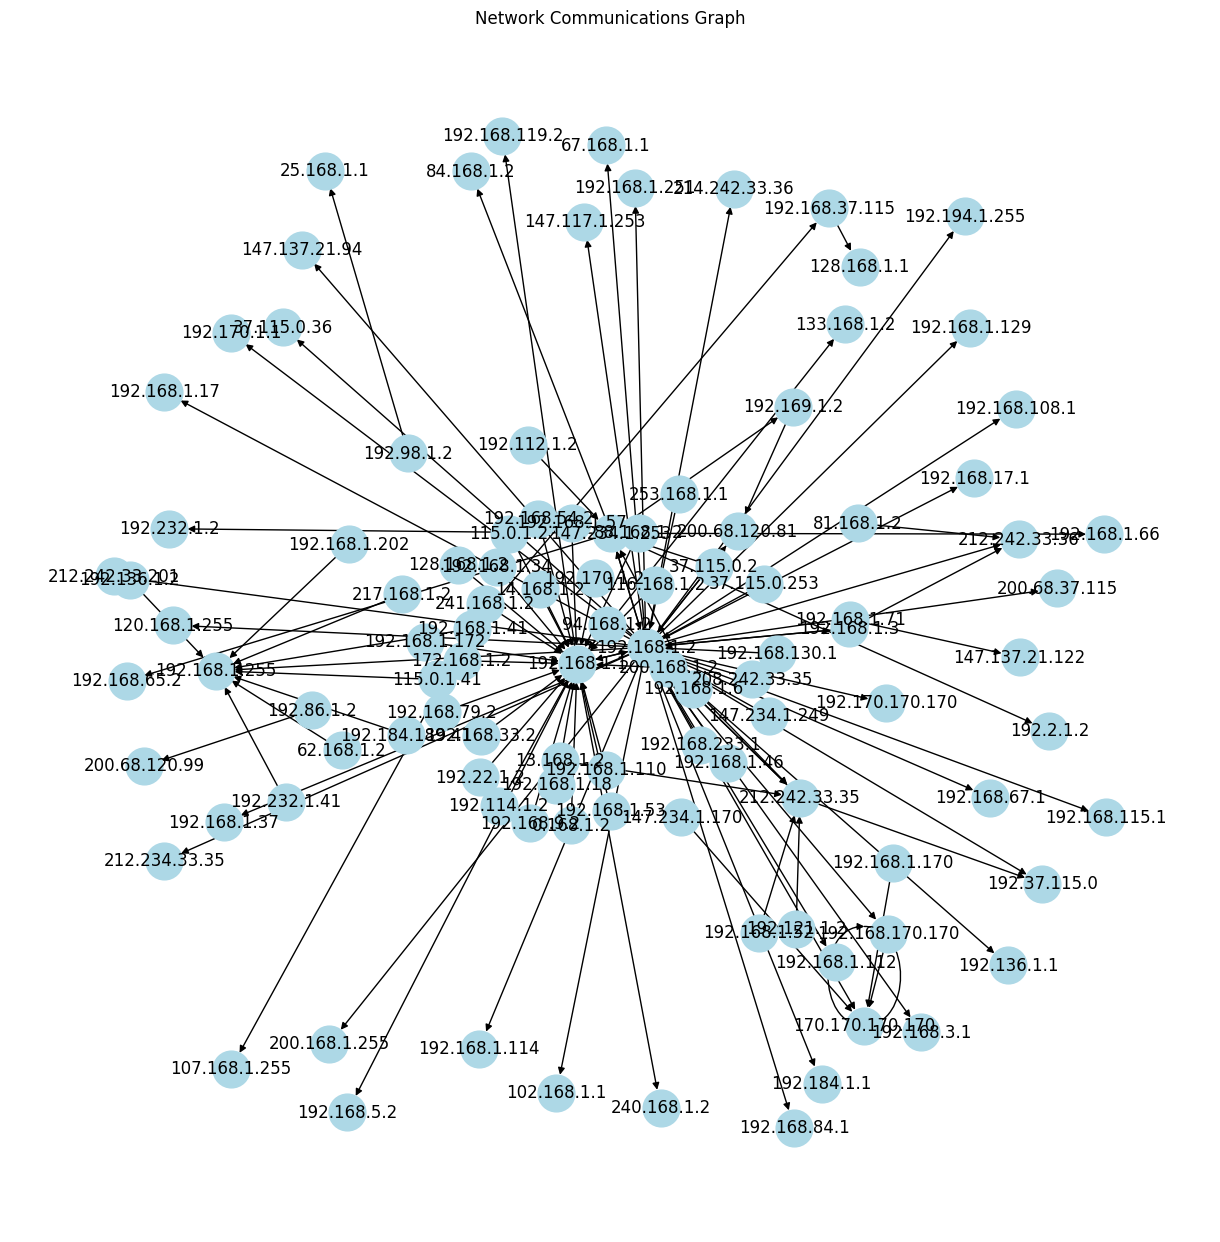

In [ ]:
import sys
import logging
from scapy.all import *
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm  # Use notebook version for better progress bar in Colab
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx

#visualization using bar and histogram
def plot_protocol_distribution(protocol_counts_df):
    plt.figure(figsize=(10, 7))
    protocol_counts_df.set_index('Protocol')['Percentage'].plot(kind='bar')
    plt.title('Protocol Distribution')
    plt.ylabel('Percentage')
    plt.xlabel('Protocol')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_packet_size_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['size'], bins=30, kde=True)
    plt.title('Distribution of Packet Sizes')
    plt.xlabel('Packet Size (bytes)')
    plt.ylabel('Frequency')
    plt.show()

#visualize how different IP address interact with each other , identifying the network tolology
def plot_network_graph(df):
    # Creating a graph from the source and destination IP addresses
    G = nx.from_pandas_edgelist(df, 'src_ip', 'dst_ip', create_using=nx.DiGraph())

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.15, iterations=20)
    nx.draw(G, pos, node_size=700, node_color='lightblue', with_labels=True, arrows=True)
    plt.title('Network Communications Graph')
    plt.show()

# Set up logging
#operater of a program, its execution state, or any errors or exceptions that occur
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)

# data processing
def read_pcap(pcap_file):
    try:
        packets = rdpcap(pcap_file)
    except FileNotFoundError:
        logger.error(f"PCAP file not found: {pcap_file}")
        return None
    except Scapy_Exception as e:
        logger.error(f"Error reading PCAP file: {e}")
        return None
    return packets

def extract_packet_data(packets):
    packet_data = []
    for packet in tqdm(packets, desc="Processing packets", unit="packet"):
        if IP in packet:
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            protocol = packet[IP].proto
            size = len(packet)
            timestamp = packet.time
            packet_data.append({"timestamp": timestamp,"src_ip": src_ip, "dst_ip": dst_ip, "protocol": protocol, "size": size})
    return pd.DataFrame(packet_data)



#Helper and Reporting Functions
def protocol_name(number):
    protocol_dict = {1: 'ICMP', 6: 'TCP', 17: 'UDP'}
    return protocol_dict.get(number, f"Unknown({number})")

#data processing
def analyze_packet_data(df):
    total_bandwidth = df["size"].sum()
    protocol_counts = df["protocol"].value_counts(normalize=True) * 100
    protocol_counts.index = protocol_counts.index.map(protocol_name)
    ip_communication = df.groupby(["src_ip", "dst_ip"]).size().sort_values(ascending=False)
    ip_communication_percentage = ip_communication / ip_communication.sum() * 100
    ip_communication_table = pd.concat([ip_communication, ip_communication_percentage], axis=1).reset_index()
    protocol_frequency = df["protocol"].value_counts()
    protocol_frequency.index = protocol_frequency.index.map(protocol_name)
    protocol_counts_df = pd.concat([protocol_frequency, protocol_counts], axis=1).reset_index()
    protocol_counts_df.columns = ["Protocol", "Count", "Percentage"]
    ip_communication_protocols = df.groupby(["src_ip", "dst_ip", "protocol"]).size().reset_index()
    ip_communication_protocols.columns = ["Source IP", "Destination IP", "Protocol", "Count"]
    ip_communication_protocols["Protocol"] = ip_communication_protocols["Protocol"].apply(protocol_name)
    ip_communication_protocols["Percentage"] = ip_communication_protocols.groupby(["Source IP", "Destination IP"])["Count"].transform(lambda x: x / x.sum() * 100)
    #ip_communication_protocols["Percentage"] = ip_communication_protocols.groupby(["Source IP", "Destination IP"])["Count"].apply(lambda x: x / x.sum() * 100)
    return total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols

#Helper and Reporting Functions
def print_results(total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols):
    if total_bandwidth < 10**9:
        bandwidth_unit = "Mbps"
        total_bandwidth /= 10**6
    else:
        bandwidth_unit = "Gbps"
        total_bandwidth /= 10**9
    logger.info(f"Total bandwidth used: {total_bandwidth:.2f} {bandwidth_unit}")
    logger.info("\nProtocol Distribution:\n")
    logger.info(tabulate(protocol_counts_df, headers=["Protocol", "Count", "Percentage"], tablefmt="grid"))
    logger.info("\nTop IP Address Communications:\n")
    logger.info(tabulate(ip_communication_table, headers=["Source IP", "Destination IP", "Count", "Percentage"], tablefmt="grid", floatfmt=".2f"))
    logger.info("\nShare of each protocol between IPs:\n")
    logger.info(tabulate(ip_communication_protocols, headers=["Source IP", "Destination IP", "Protocol", "Count", "Percentage"], tablefmt="grid", floatfmt=".2f"))

def main():
    # Upload file
    uploaded = files.upload()
    if not uploaded:
        logger.error("No file uploaded.")
        return
    pcap_file = next(iter(uploaded))
    # Set a default port_scan_threshold value
    port_scan_threshold = 100  # Adjust or prompt for input if needed

    packets = read_pcap(pcap_file)
    if packets is None:
        return
    df = extract_packet_data(packets)
    total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols = analyze_packet_data(df)
    print_results(total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols)

    # Plotting the results
    #Knowing which protocols are most heavily used can help in optimizing network settings or capacities tailored to those protocols for better performance.
    plot_protocol_distribution(protocol_counts_df)
    # Significant deviations from typical packet size distributions might indicate issues like malicious activities
    plot_packet_size_distribution(df)


    #Unusual patterns, such as unexpected connections can be quickly spotted and investigated further for potential security
    plot_network_graph(df)


    #-----







if __name__ == "__main__":
    main()
